<a href="https://colab.research.google.com/github/NeemaNdanu/Natural-language-processing/blob/main/NLP_FINAL_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**4. Text Classification in African Languages**

**o Objective:** Develop a model to classify text documents in an African language (e.g., news articles, social media posts) by topic (e.g., sports, politics, entertainment).

**o Tasks:**Use or collect a labeled dataset, preprocess it, and train a classification model.

**o Expected Outcome:** A classifier that can categorize texts into predefined topics with a reasonable accuracy.

**Information About the Dataset**

Due to the limited availability of datasets for the Kamba language, this dataset was created from scratch. To ensure the dataset's accuracy, I consulted with an expert to review the data. After receiving confirmation that the dataset was appropriate, I proceeded with its use.

The dataset consists of around 600 sentences, with 150 sentences in Kamba and 150 corresponding translated sentences in English. It also includes 5 labels:

- **Business**
- **Biblical**
- **Political**
- **Sports**
- **Academic**

This dataset is structured to facilitate the classification of Kamba text into these five categories.

I decided to take on this project, focusing on the Kamba language, for several reasons:

- **Support for Rural Businesses**: The goal is to help businesses in Kamba-speaking areas, like Machakos and Makueni, use text classification models to automate customer support. This would enable businesses to better understand and respond to Kamba-speaking customers, improving service efficiency.
  
- **Educational Support for Children**: The project also aims to assist children in rural areas. By leveraging text classification models, universities and schools in these regions can develop educational tools, such as automated quizzes, content categorization, or translation aids, to better support students' learning.

**IMPORT AND SETUP**

In [ ]:
# Step 1: Clone the GloVe repository
!git clone https://github.com/stanfordnlp/glove
%cd glove

# Step 2: Install necessary dependencies
!apt-get install -y make g++ wget

# Step 3: Compile the code
!make

# Step 4: Prepare the Kamba dataset
import pandas as pd

# Load the Excel dataset
data = pd.read_excel('/content/KAMBA DATASET.xlsx')

# Save the text data to a file (for GloVe input)
with open('/content/kamba_text.txt', 'w') as f:
    for text in data['TEXT']:
        f.write(str(text) + '\n')

# Move the file into the GloVe directory
!cp /content/kamba_text.txt .

# Step 5: Train GloVe on the Kamba corpus
!./demo.sh


fatal: destination path 'glove' already exists and is not an empty directory.
/content/glove
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
make is already the newest version (4.3-4.1build1).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
mkdir -p build
mkdir -p build

$ build/vocab_count -min-count 5 -verbose 2 < text8 > vocab.txt
BUILDING VOCABULARY
Processed 0 tokens.100000 tokens.200000 tokens.300000 tokens.400000 tokens.500000 tokens.600000 tokens.700000 tokens.800000 tokens.900000 tokens.1000000 tokens.1100000 tokens.1200000 tokens.1300000 tokens.1400000 tokens.1500000 tokens.1600000 tokens.1700000 tokens.1800000 tokens.1900000 tokens.2000000 tokens.2100000 tokens.2200000 tokens.2300000 tokens.2400000 tokens.2500000 tokens.2600000 tokens.2700000 tokens.2800000 tokens.2900000 tokens.3000000 tokens.3100000 

The code above made Glove embeddings from the actual dataset whihc will be later be used for training the model.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import re
import string
import transformers
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import logging
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from transformers import AdamW
import optuna
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

# Suppress warnings for cleaner output
logging.set_verbosity_error()

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


**1. DATA LOADING**



In [ ]:
# Load data
path = "/content/KAMBA DATASET.xlsx"
data = pd.read_excel(path)

# Filter data to keep only relevant columns and rows
data = data[data['VERSION'].str.startswith('O:')]
data = data.dropna(subset=['TEXT'])
data = data[['TEXT', 'LABEL']].copy()

# Verify dataset structure
print("Dataset Columns:", data.columns)
print("Unique Labels:", set(data['LABEL'].values.tolist()))

Dataset Columns: Index(['TEXT', 'LABEL'], dtype='object')
Unique Labels: {'Business', 'Biblical', 'Political', 'Sports', 'Academic'}


Since the dataset contained both English and Kamaba text the above code only extracted the Kamba text and removed any missing values that may have existed in the excel file.

It also showed what labels are there in the datasets  and from it we were able to obtain 5 lables :- 'Business', 'Biblical', 'Political', 'Sports', 'Academic'

<Figure size 800x800 with 0 Axes>

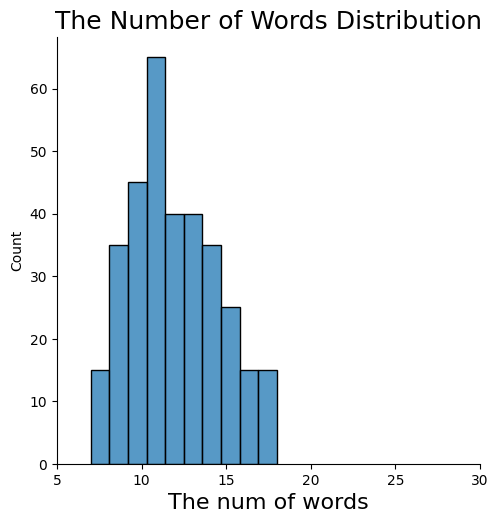

In [ ]:
# Create a new column 'count' representing the number of words in 'TEXT'
data['count'] = data['TEXT'].apply(lambda text: len(text.split()))

plt.figure(figsize=(8, 8))
sns.displot(data['count'])
plt.xlim(5, 30)
plt.xlabel('The num of words', fontsize=16)
plt.title('The Number of Words Distribution', fontsize=18)
plt.show()

The above code visualize the frequency of words in the text and form it we see that the most frequent number of words are between 10- 15.

In [ ]:
data['LABEL'].value_counts()

,count
LABEL,
Political,80
Academic,70
Biblical,60
Business,60
Sports,60


The above code tries to count how may text or sentence are labeled as a certain catergory. Form it we see that the the  label Political has highest number and least are Bibilical, Business and Sports.

The code below is a visual represenation of the frequencies of the label

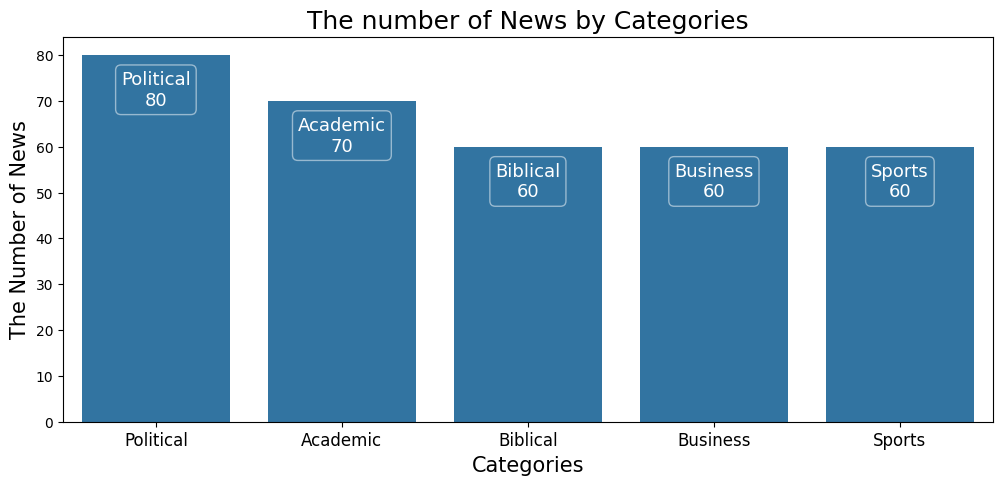

In [ ]:
# Count each category
category_count = data['LABEL'].value_counts()

# Define categories based on the index of category_count
categories = category_count.index.tolist()

# Now proceed with your plotting code
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

# Use 'category_count' as intended
sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

**2. DATA PREPROCESSING**

Although the dataset was created from scratch, data preprocessing was necessary to ensure consistency and usability. The preprocessing steps included the following:

* **Conversion to lowercase:** Standardized all text to lowercase.
* **Removal of non-numeric and alphanumeric characters:** Eliminated unwanted characters to clean the dataset.
* **Trimming extra spaces:** Removed redundant spaces for uniformity.
* **Tokenization:** Split text into individual words (word split).
* **Stopword removal:** Filtered out common, non-informative words.
* **Punctuation removal:** Excluded punctuation marks.
* **Normalization:** Processed text for consistency by reducing variations
* **Removal of special characters and symbols:** Cleared any remaining unwanted elements.

For stopwords, a custom approach was applied. Since Kamba, a Bantu language, is closely related to Swahili, Swahili stopwords were used as a basis for this process.

Regarding punctuation, as there is no standard punctuation specific to Bantu languages, I combined elements of English and Swahili punctuation to create a set exclusively tailored for Kamba.

In [ ]:
# Load Swahili stopwords
path = "/content/swahili_stopwords.csv"
swahili_stopwords = pd.read_csv(path, header=None, encoding='latin-1')
swahili_stopwords = swahili_stopwords[0].tolist()

# Function to preprocess Kamba text
def preprocess_kamba_text(text, stopwords):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Join words back into a string
    return ' '.join(words)

# Function to remove punctuations
def remove_punctuations(text):
    # Define English punctuations
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

# Function to normalize text
def normalize_text(text):
    # Remove non-alphabetic characters and special symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# General text preprocessing pipeline
def preprocess_text(text, stopwords):
    # Remove punctuation
    text = remove_punctuations(text)
    # Normalize text
    text = normalize_text(text)
    # Tokenize and remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [ ]:
# Print a sample of the processed text
data['Text'] = data['TEXT'].apply(normalize_text)

texts = data['Text'].values
labels = data['LABEL'].values

texts[0], labels[0]

('mnini kvnd k tonyi nth n ky nene kkwendeka ktetheesya and ma nth',
 'Political')

**3. DATA PREPARATION FOR MODELLING**

**Objective:** Tokenize and encode the text data for the classification model.

In this step we encoded the labales that is conversion of the categorical labels into numeric format



In [ ]:
# One hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

encoder.categories_

[array(['Academic', 'Biblical', 'Business', 'Political', 'Sports'],
       dtype=object)]

The data is split into trin and tetx in the ration 80-20

It then converts text into sequences of word indices and pads them to a fixed length for input into the neural network.



In [ ]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


Here is how tokenization was done:-
 1. The Tokenizer is created with the num_words parameter set to max_words, limiting the vocabulary to the max_words most common words in the dataset. Less frequent words are ignored.

 2. The fit_on_texts method processes train_texts (a list of sentences) and creates a vocabulary. Each unique word is assigned a unique integer index, with more frequent words getting smaller indices.

 3. The texts_to_sequences method transforms each sentence into a list of integers, where each integer corresponds to a word's index in the vocabulary. Words not in the vocabulary are skipped.

 4. The sequences are padded to a fixed length using pad_sequences, ensuring uniform input size for the neural network.



In [ ]:
max_words = 1000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_data = pad_sequences(train_sequences, maxlen=max_len)
test_data = pad_sequences(test_sequences, maxlen=max_len)


In [ ]:
train_data[0].shape, train_labels[0].shape


((200,), (5,))

**4. LOAD GLOVE EMBEDDINGS**

At the start of this project, I created my own embeddings directly from the dataset. However, the code below now focuses on loading pre-trained GloVe embeddings into a dictionary for use.

So mainly my code does the following :-
 * The pre-trained GloVe embeddings are stored as a text file.
 * Each line contains a word followed by its embedding vector (a series of numerical values representing the word).
 * The code reads this file line by line, extracting each word and its corresponding vector.
 * These word-embedding pairs are then stored in a Python dictionary for easy access during the project.

In [ ]:
# Load GloVe embeddings
embedding_index = {}
glove_path = "/content/glove/vectors.txt"
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 71291 word vectors from GloVe.


The otput 71291 word vectors shows that the code successfully read and processed 71,291 unique words from the GloVe file.

The code below on emebdding matrix then maps the tokenized vocabulary to their corresponding GloVe vectors.

In [ ]:
# Create embedding matrix
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**5. DEFINE AND TRAIN THE MODEL**

The code below does the following :-
 * Builds an LSTM model using pre-trained GloVe embeddings.
 * Compiles the model with categorical crossentropy loss and the Adam optimizer.
 * Trains the model on the processed dataset.

In [ ]:
# Define the classification model
model = Sequential()
model.add(Embedding(input_dim=max_words,output_dim=embedding_dim,input_length=max_len,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")

Embedding matrix shape: (1000, 50)
Train data shape: (264, 200)
Train labels shape: (264, 5)


The above results mean the following:-

1. The maximum vocabulary size, meaning it contains embeddings for up to 1000 unique words. and for The each its dimensionality is 50.

2. The number of training samples is 264 and the length of each text after padding is truncated or padded to a fixed length of 200 tokens.

3. The number of samples in the training data is 264 with a total of 5 unique lables in the sample.


**6. EVALUATE THE MODEL**

Here the code trian the model and then evaluates the model on the test set and prints the loss and accuracy.

In [ ]:
# Train the model
history = model.fit(train_data, train_labels, validation_split=0.2, batch_size=32, epochs=10, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 855ms/step - accuracy: 0.3102 - loss: 1.5749 - val_accuracy: 0.3208 - val_loss: 1.5443
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 630ms/step - accuracy: 0.4745 - loss: 1.4884 - val_accuracy: 0.3396 - val_loss: 1.4947
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.4394 - loss: 1.4111 - val_accuracy: 0.3774 - val_loss: 1.4134
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.4769 - loss: 1.3103 - val_accuracy: 0.4717 - val_loss: 1.2994
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.5880 - loss: 1.2138 - val_accuracy: 0.5094 - val_loss: 1.2122
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.6134 - loss: 1.0689 - val_accuracy: 0.5283 - val_loss: 1.1424
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.6132 - loss: 1.0488 - val_accuracy: 0.5472 - val_loss: 1.0685
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.6366 - loss: 0.9498 - val_accuracy: 0.6038 - val_los

Form the output above as training progresses the following happens:-
 * Training accuracy increases thus showing that the model is learning patterns in the training data.
 * Validation accuracy improves initially, then stabilizes which shows the model generalizes better to unseen data as it learns.
 * Training and validation losses decreasewhcih suggests that the model is fitting the data better while avoiding overfitting.

At the end of it all we see that the the loss on the test dataset is 1.2711 which  indicates how well the model performs on unseen data.

Also the test accuracy is 56.06%, meaning the model correctly predicts about 56% of the test samples


**7. HYPERPARAMETER TUNING**

Since the previous model achieved an accuracy of around 56%, I decided to optimize the model's hyperparameters to potentially improve its performance. The code below uses Optuna, a powerful hyperparameter optimization library, to systematically search for the best combination of parameters for the LSTM model.

This process involves varying key parameters such as:

* Number of LSTM units: Determines the complexity of the LSTM layer.
* Dropout rate: Helps prevent overfitting by randomly dropping connections during training.
* Learning rate: Controls how much the model's weights are updated during training.

With the code we have the folloing parts:-

**1. Define the Model Creation Function (create_model)**

The main purpose for this fucntion is to build the LSTM model with hyperparameters suggested by Optuna.Here we have the following key components:-

  * Embedding Layer that converts word indices into dense vectors using a pre-trained embedding matrix.
  * LSTM Layer that uses the lstm_units parameter suggested by Optuna to define the number of units in the LSTM.
  * Dense Layer that outputs predictions for each class using the softmax activation function.
  * Optimizer that uses the Adam optimizer with a learning rate determined by Optuna.

**2.  Define the Objective Function (objective)**

The purpose for this function is to train the model and evaluate its validation accuracy to guide Optuna's optimization process. Within it we have the following steps:

  * Create a model with hyperparameters suggested by the current trial.
  * Train the model using the training data, with a validation split of 20%.
  * Use early stopping to halt training if validation loss doesn't improve for 3 consecutive epochs, avoiding unnecessary computation.
  * Return the highest validation accuracy during training for Optuna to evaluate this trial.

**3. Run the Optimization (study.optimize)**

The main purpose for this last step is to  executes multiple trials to find the best hyperparameter combination.It contains the following key components:-
  
  * Optuna Study that configures to maximize the validation accuracy.
  * Number of Trials that is limited to 10.

In [ ]:
# Hyperparameter tuning using Optuna
def create_model(trial):
    # Keep embedding_dim fixed to match the pre-trained matrix
    embedding_dim = 50
    lstm_units = trial.suggest_int('lstm_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(train_data, train_labels, validation_split=0.2, batch_size=32, epochs=20, callbacks=[early_stopping], verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.params}")

[I 2024-11-26 11:30:48,743] A new study created in memory with name: no-name-1d0128a1-bc54-4c0f-802d-85086b037921
<ipython-input-22-8ec161419398>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-11-26 11:31:57,717] Trial 0 finished with value: 0.7547169923782349 and parameters: {'lstm_units': 92, 'dropout_rate': 0.27412972672063507, 'learning_rate': 0.002394870351500044}. Best is trial 0 with value: 0.7547169923782349.
[I 2024-11-26 11:33:03,865] Trial 1 finished with value: 0.5283018946647644 and parameters: {'lstm_units': 139, 'dropout_rate': 0.23562410842641496, 'learning_rate': 0.000198

Best trial: {'lstm_units': 92, 'dropout_rate': 0.27412972672063507, 'learning_rate': 0.002394870351500044}


After running the optimization Optuna prints the combination of hyperparameters that achieved the highest validation accuracy.

The best trial contains teh folllwing :-
 * lstm_units: 92
 * dropout_rate: 0.27412972672063507
 * learning_rate: 0.002394870351500044

**8. MODEL TRIANING WITH OPTIMAL HYPERPARAMETERS**

Here the code does the following :-
 * Retrieves the best hyperparameter values for LSTM units, dropout rate, and learning rate after tuning.
 * Recreate the model with optimal hyperparameters where:-
    - An embedding layer converts words into dense vectors.
    - An LSTM layer captures sequential dependencies, with dropout regularization.
    - The final dense layer outputs probabilities for each class

 * The model is trianed on the training data, using 20% for validation and the training history (loss and accuracy) is stored for visualization.
 * Plots loss and accuracy trends across epochs to monitor performance.



Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.2322 - loss: 1.6029 - val_accuracy: 0.2075 - val_loss: 1.5855
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 727ms/step - accuracy: 0.2626 - loss: 1.5364 - val_accuracy: 0.2642 - val_loss: 1.5483
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.4558 - loss: 1.4096 - val_accuracy: 0.5660 - val_loss: 1.3813
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.7503 - loss: 1.1902 - val_accuracy: 0.6981 - val_loss: 1.0549
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.7367 - loss: 0.8646 - val_accuracy: 0.7547 - val_loss: 0.7432
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.8605 - loss: 0.5565 - val_accuracy: 0.7925 - val_loss: 0.4976
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.9151 - loss: 0.3307 - val_accuracy: 0.9245 - val_loss: 0.3581
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.9597 - loss: 0.2134 - val_accuracy: 0.8868 - val_loss:

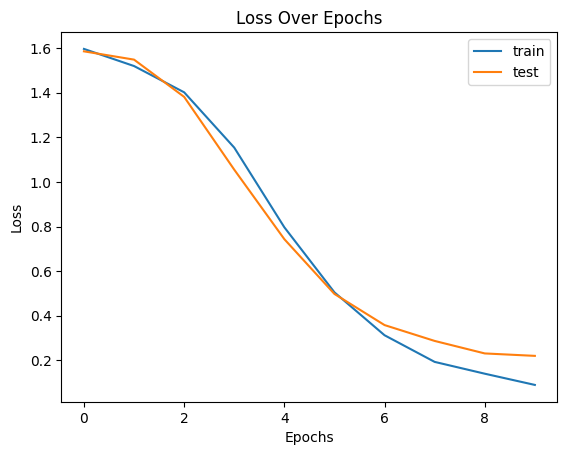

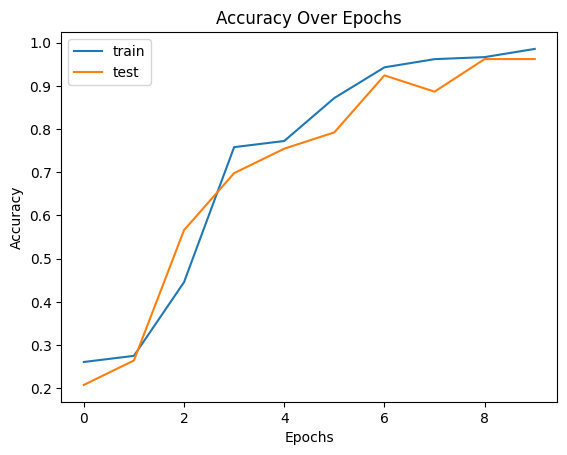

In [ ]:
# Use the best hyperparameters from Optuna
best_lstm_units = study.best_trial.params['lstm_units']
best_dropout_rate = study.best_trial.params['dropout_rate']
best_learning_rate = study.best_trial.params['learning_rate']

# Define batch size and epochs
batch_size = 32
epochs = 10

# Check and convert train_labels to one-hot encoding
if len(train_labels.shape) == 1:
    num_classes = 5
    train_labels = keras.utils.to_categorical(train_labels, num_classes=num_classes)

# Recreate the model with optimal hyperparameters
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)) # Use embedding_dim here
model.add(LSTM(best_lstm_units, dropout=best_dropout_rate, recurrent_dropout=best_dropout_rate))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the best hyperparameters
history = model.fit(train_data, train_labels, validation_split=0.2, batch_size=batch_size, epochs=epochs)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


From the output we get the folllowing reults :-

* The model starts with poor performance, as it is randomly initialized and still learning patterns.
* Training and validation metrics improve significantly.
* Loss decreases, and accuracy rises as the model learns better representations of the data this indicats the model is learning effectively.

For the loss over epoch we have the following trends:-
 * Training loss decreases steadily across epochs, with a sharper decline in early epochs and flattening out later.
 * Validation loss follows a similar trend, though it may fluctuate slightly more due to the smaller validation set.

For the accuracy over epoch we have the following trends:-
 * Training accuracy increases rapidly, starting from 23% and reaching 99.58% by Epoch 10.
 * Validation accuracy mirrors this trend, though it plateaus slightly earlier and stabilizes at a slightly lower value 96.23%.



**9. EVALUATE THE MODEL**


In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Accuracy: %f' % (accuracy))


Accuracy: 0.878788


After tuning the hyperparameters the accuracy levels increases form 56% to 87%

In [ ]:
# Get predicted labels for test data
y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels

# Convert y_true to multiclass format
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
Classification Report:
              precision    recall  f1-score   support

    Academic       0.75      1.00      0.86        12
    Biblical       1.00      0.76      0.87        17
    Business       1.00      1.00      1.00        14
   Political       0.75      1.00      0.86        12
      Sports       1.00      0.64      0.78        11

    accuracy                           0.88        66
   macro avg       0.90      0.88      0.87        66
weighted avg       0.91      0.88      0.88        66



The classification report generated  provides the following information :-    
* Academic has a high recall (1.00), indicating all true "Academic" instances were predicted correctly.Precision is slightly lower (0.75), suggesting some incorrect predictions as "Academic."
* Biblical has a High precision (1.00), meaning all instances predicted as "Biblical" are correct.Recall is lower (0.76), indicating some true "Biblical" instances were missed.
* Business has Perfect precision, recall, and F1-score (1.00), meaning no misclassifications for this category.
* Political similar to "Academic," recall is perfect (1.00), but precision is slightly lower (0.75).
* Sports has a high precision (1.00), but lower recall (0.64), indicating many true "Sports" instances were missed.

The overall accuracy is 0.88 which is 88 % which is a better accuracy after fine tuning.

The macro average F1-score is 0.87, reflecting a balanced overall performance.

The weighted average F1-score is 0.88, closely matching the accuracy.

**Save the model**

The model is saved and later used for predictions

In [ ]:
# Save the model
model.save('models.keras')


**10. PREPROCESSING FOR INFERENCE**

The code below does the following :-
* Convert text to token sequences using a trained tokenizer.
* Pads the sequences to a fixed length (max_len) for consistent input shape.

In [ ]:
# Pre-process for inference
def pre_process(tokenizer, max_len, input_text):
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_data = pad_sequences(input_sequence, maxlen=max_len)
    return input_data


**11. PREDICT THE MODEL**

Here the model :-
* Predicts probabilities for all classes and formats them as percentages.
* Identifies the class with the highest predicted probability.

In [ ]:
def classify_text(model, tokenizer, encoder, max_len, input_text):
    input_data = pre_process(tokenizer, max_len, input_text)
    pred = model.predict(input_data)
    result_dict = {}

    for i, LABEL in enumerate(encoder.categories_[0]):
        result_dict[LABEL] = str(round(pred[0][i] * 100, 2))+'%'

    highest_prob = max(result_dict, key=result_dict.get)

    return (result_dict, highest_prob)


**Prediction on an existing text from dataset**

The three continuous code blocks perform two main tasks: :-
* Extracting a sentence from the dataset to check the model's prediction accuracy.
* Predicting the category of a new input sentence.

In [ ]:
# Pick a random news headline from dataset
news_ = data.sample(1)

text_comment = news_['Text'].values[0]
text_category = news_['LABEL'].values[0]

result_dict, classified_label = classify_text(model, tokenizer, encoder, max_len, text_comment)

print(f'News headline: {text_comment}')
print(f'Actual category: {text_category}')
print(f'Predicted category: {classified_label}')
print(f'Confidence scores: {result_dict}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
News headline: ksoma n kwlka wendo msy ma tonyi kvathka
Actual category: Academic
Predicted category: Academic
Confidence scores: {'Academic': '98.99%', 'Biblical': '0.37%', 'Business': '0.04%', 'Political': '0.6%', 'Sports': '0.01%'}


In [ ]:
# Pick another random text
news_ = data.sample(1)

text_comment = news_['Text'].values[0]
text_category = news_['LABEL'].values[0]

result_dict, classified_label = classify_text(model, tokenizer, encoder, max_len, text_comment)

print(f'News headline: {text_comment}')
print(f'Actual category: {text_category}')
print(f'Predicted category: {classified_label}')
print(f'Confidence scores: {result_dict}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
News headline: msumb n mwanya ktetheesya nguliko kwsmbanya nth mtetheo mla maendeeo
Actual category: Political
Predicted category: Political
Confidence scores: {'Academic': '0.13%', 'Biblical': '0.0%', 'Business': '0.01%', 'Political': '99.86%', 'Sports': '0.0%'}


In [ ]:
# Pick a random news headline from dataset
news_ = data.sample(1)

text_comment = news_['Text'].values[0]
text_category = news_['LABEL'].values[0]

result_dict, classified_label = classify_text(model, tokenizer, encoder, max_len, text_comment)

print(f'News headline: {text_comment}')
print(f'Actual category: {text_category}')
print(f'Predicted category: {classified_label}')
print(f'Confidence scores: {result_dict}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
News headline: vinya msy tetheesya kwtma kyma ksunga msy ma maendeeo
Actual category: Business
Predicted category: Business
Confidence scores: {'Academic': '0.31%', 'Biblical': '0.04%', 'Business': '99.59%', 'Political': '0.05%', 'Sports': '0.01%'}


**Prediction on New Sentences**

The code below does the following
 * A new, unseen sentence is input into the function.
 * The sentence is preprocessed the same way as was done earlier during training
 * The processed sentence is passed through the trained model, which outputs probabilities for all possible categories.
 * The category with the highest probability is identified as the predicted label.
 * The predicted label is mapped back to its category name (using the encoder) and returned as the result.

In [ ]:
# Function to predict the category of a new sentence
def predict_new_sentence(sentence, tokenizer, model, max_len=200):
    # Preprocess the sentence
    preprocessed_text = preprocess_kamba_text(sentence, swahili_stopwords)

    # Tokenize the preprocessed text
    sequence = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the sequence to ensure it has the correct shape
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Make the prediction
    prediction = model.predict(padded_sequence)

    # Get the label with the highest probability
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Get the category name from the label (inverse transformation of one-hot encoding)
    category = encoder.categories_[0][predicted_label]

    return category

# Test the function with a new sentence
new_sentence = "Mundu wa wikala museo aanake wa kwikya utumi wake muno wa usukuani, no asyoka atembe na mwioyo wa kwiitika uw'o kwa andu ake."
predicted_category = predict_new_sentence(new_sentence, tokenizer, model)
print(f"Predicted category for the new sentence: {predicted_category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Predicted category for the new sentence: Political
